<a href="https://colab.research.google.com/github/aiguozhe01/DIC_Assignment/blob/master/Sprint_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 深層学習スクラッチ ニューラルネットワーク

In [1]:
import numpy as np
from fractions import Fraction

from sklearn.model_selection import train_test_split
from keras.datasets import mnist

import tensorflow as tf

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [2]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

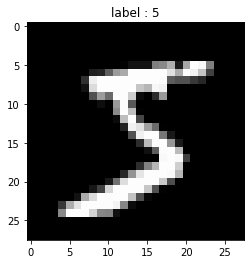

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

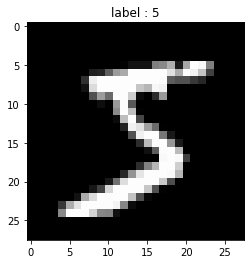

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [4]:
index = 0
image = X_train[index].reshape(28,28)

image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる

plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [8]:
import copy
import time

class Linear:
    """
    線形結合
    
    Parameters
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dZ_ : 次の形のndarray, shape (batch_size, n_nodes_prev)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (n_nodes_self, )
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        b : 次の形のndarray, shape (n_nodes_self, )
          ある層のバイアス
        """
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        dA : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたAに関するLoss勾配
        """
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

        
class Sigmoid:
    """
    シグモイド関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_
        
        
class Tanh:
    """
    ハイパーボリックタンジェント関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_

    
class Softmax:
    """
    SoftMax関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
          正解ラベルデータ
        """
        self.dA_ = self.Z_ - y
        
        return self.dA_
                         
        
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    
        
class ScratchSimpleNeuralNetworkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    
    Parameters
    ----------
    epoch : int
      エポック数
    lr : float
      学習率
    sigma : float
      初期パラメータ用
    n_nodes1 : int
      1層目のノード数
    n_nodes2 : int
      2層目のノード数
    n_output : int
      出力層のノード数
    batch_size : int
      ミニバッチのサンプル数
      
    Attributes
    ----------
    w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      重みパラメータ
    b : 次の形のndarray, shape (n_nodes_self, )
      バイアスパラメータ
    loss_train : list
      訓練データに対するLoss
    loss_val : list
      検証データに対するLoss
    verbose : bool
      学習経過の出力
    """
    
    def __init__(self, epoch=10, sigma=0.1, lr=0.1, n_nodes1=400, n_nodes2=200, n_output=10, batch_size=20, verbose=False, **kwargs):
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.batch_size = batch_size
        self.w = None
        self.b = None
        self.loss_train = []
        self.loss_val = []
        self.verbose = verbose


    def _params_init(self, n_features, n_output):
        """
        3層ニューラルネット用のパラメータ初期化関数

        Returns
        -------
        w_params : list
          各層の重みを格納したリスト
        b_params : list
          各層のバイアスを格納したリスト
        """
        W1 = self.sigma * np.random.randn(n_features, self.n_nodes1)
        W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        W3 = self.sigma * np.random.randn(self.n_nodes2, n_output)

        B1 = np.random.randn(self.n_nodes1)
        B2 = np.random.randn(self.n_nodes2)
        B3 = np.random.randn(n_output)

        w_params = np.array((W1, W2, W3))
        b_params = np.array((B1, B2, B3))

        return w_params, b_params
    

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, n_classes)
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, n_classes)
            検証データの正解値
        """
        w, b = self._params_init(len(X[0]), self.n_output)

        # レイヤーインスタンスを作成
        linear_1 = copy.deepcopy(Linear())
        activ_1 = copy.deepcopy(Sigmoid())
        linear_2 = copy.deepcopy(Linear())
        activ_2 = copy.deepcopy(Sigmoid())
        linear_3 = copy.deepcopy(Linear())
        softmax = copy.deepcopy(Softmax())

        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            
            start = time.time()
            
            # 各mini batchの損失をリスト化
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:
                
                # 順伝播
                A1 = linear_1.forward(X_mini, w[0], b[0])
                Z1 = activ_1.forward(A1)

                A2 = linear_2.forward(Z1, w[1], b[1])
                Z2 = activ_2.forward(A2)

                A3 = linear_3.forward(Z2, w[2], b[2])
                Z3 = softmax.forward(A3)

                # 逆伝播
                dA3 = softmax.backward(y_mini)
                dZ2, dw3, db3 = linear_3.backward(Z2, w[2], dA3)

                dA2 = activ_2.backward(dZ2)
                dZ1, dw2, db2 = linear_2.backward(Z1, w[1], dA2)

                dA1 = activ_1.backward(dZ1)
                _, dw1, db1 = linear_1.backward(X_mini, w[0], dA1)

                # 確率的勾配降下法
                w -= self.lr * np.array((dw1, dw2, dw3)) 
                b -= self.lr * np.array((db1, db2, db3)) 
                
                # 損失関数
                loss_batch_t.append(self.cross_entropy(Z3, y_mini, len(X_mini)))
            
            # 各epochの平均損失をselfに格納
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # 検証データの推定
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    A1 = linear_1.forward(X_mini, w[0], b[0])
                    Z1 = activ_1.forward(A1)

                    A2 = linear_2.forward(Z1, w[1], b[1])
                    Z2 = activ_2.forward(A2)

                    A3 = linear_3.forward(Z2, w[2], b[2])
                    Z3 = softmax.forward(A3)
                
                    loss_batch_v.append(self.cross_entropy(Z3, y_mini, len(X_mini)))
            
                # 各epochの平均損失をselfに格納
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)
            
            end = time.time()
            
            times.append(end-start)


            if self.verbose and (i+1) % 10 == 0:
                print("Epoch {}; Loss {:.4f}".format(i+1, loss_train),
                      "  --Avg Epoch Time {:.4f}sec".format(np.mean(times)))
                
        # 全epoch終了後のパラメータを保存    
        self.w = w
        self.b = b

            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, )
            推定結果
        """
        A1 = Linear().forward(X, self.w[0], self.b[0])
        Z1 = Sigmoid().forward(A1)

        A2 = Linear().forward(Z1, self.w[1], self.b[1])
        Z2 = Sigmoid().forward(A2)

        A3 = Linear().forward(Z2, self.w[2], self.b[2])
        Z3 = Softmax().forward(A3)
        
        return np.argmax(Z3, axis=1)
        
    
    def cross_entropy(self, X, y, batch_size):
        """
        クロスエントロピー誤差を計算

        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
          入力データ
        y : 次の形のndarray, shape (batch_size, n_classes)
          入力データの正解ラベル

        Returns
        -------
          float
          クロスエントロピー誤差
        """
        return (-1/batch_size) * np.sum((y*np.log(X)))

In [9]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [10]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([9, 0, 4, 3, 8, 0, 7, 6, 3, 2, 6, 7, 3, 8, 1, 4, 7, 0, 6, 0],
      dtype=uint8))


## 【問題1】重みの初期値を決めるコードの作成

1. ニューラルネットワークの各層の重みの初期値を決めるコードを作成する。
    * 重みの初期値はガウス（正規）分布による単純な初期化を行う。
    * バイアスに関しても同様
    * サンプルコードの標準偏差の値sigmaはハイパーパラメータ。
    

In [ ]:
n_features = 784
n_nodes1 = 400
n_nodes2 = 200
n_output = 10
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
W3 = sigma * np.random.randn(n_nodes2, n_output)
# W1: (784, 400)

#################
# he_initialization = np.random.randn(size_l, size_l_1) * np.sqrt(2/size_l_1)
# xavier_initialization = np.random.randn(size_l, size_l_1) * np.sqrt(1/size_l_1)
# Xavier initialization which considers the size of the network(number of input and output units) while initializing weights.
#################

In [11]:
def params_init_():
    """
    3層ニューラルネット用のパラメータ初期化関数
    
    Returns
    -------
    w_params : list
      各層の重みを格納したリスト
    b_params : list
      各層のバイアスを格納したリスト
    """
    n_features = 784
    n_nodes1 = 400
    n_nodes2 = 200
    n_output = 10
    sigma = 0.01 # ガウス分布の標準偏差

    W1 = sigma * np.random.randn(n_features, n_nodes1)
    W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
    W3 = sigma * np.random.randn(n_nodes2, n_output)

    B1 = sigma * np.random.randn(n_nodes1)
    B2 = sigma * np.random.randn(n_nodes2)
    B3 = sigma * np.random.randn(n_output)
    
    w_params = np.array((W1, W2, W3))
    b_params = np.array((B1, B2, B3))
    
    return w_params, b_params

In [12]:
w, b = params_init_()
print(w[0].shape)
print(b[0].shape)

(784, 400)
(400,)


## 【問題2】フォワードプロパゲーションの実装

1. 三層のニューラルネットワークの**フォワードプロパゲーション**を作成する。
    * batch_size = 20 # バッチサイズ
    * n_features = 784 # 特徴量の数
    * n_nodes1 = 400 # 1層目のノード数
    * n_nodes2 = 200 # 2層目のノード数
    * n_output = 10 # 出力のクラス数（3層目のノード数）


In [13]:
class Linear:
    """
    線形結合
    
    Parameters
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    """
    def __init__(self):
        self.A_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        b : 次の形のndarray, shape (n_nodes_self, )
          ある層のバイアス
        """
        self.A_ = Z @ w + b
        
        return self.A_
    
        
class Sigmoid:
    """
    シグモイド関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    """
    def __init__(self):
        self.Z_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
        
class Tanh:
    """
    ハイパーボリックタンジェント関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    """
    def __init__(self):
        self.Z_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.tanh(A)
        
        return self.Z_

    
class Softmax:
    """
    SoftMax関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    """
    def __init__(self):
        self.Z_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
                         

def fit(X):
    """
    ニューラルネットワーク分類器を学習する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
    """
    w, b = params_init_()
    
    # レイヤーインスタンスを作成
    linear_1 = Linear()
    sigmoid_1 = Sigmoid()
    linear_2 = Linear()
    sigmoid_2 = Sigmoid()
    linear_3 = Linear()
    softmax = Softmax()
    
    A1 = linear_1.forward(X, w[0], b[0])
    print(A1.shape)
    Z1 = sigmoid_1.forward(A1)
    print(Z1.shape)
    A2 = linear_2.forward(Z1, w[1], b[1])
    print(A2.shape)
    Z2 = sigmoid_2.forward(A2)
    print(Z2.shape)
    A3 = linear_3.forward(Z2, w[2], b[2])
    print(A3.shape)
    Z3 = softmax.forward(A3)

In [14]:
fit(X_train)

(48000, 400)
(48000, 400)
(48000, 200)
(48000, 200)
(48000, 10)


## 【問題3】交差エントロピー誤差の実装

In [15]:
def cross_entropy(X, y, batch_size):
    """
    クロスエントロピー誤差を計算

    Parameters
    ----------
    X : 次の形のndarray, shape (batch_size, n_features)
      入力データ
    y : 次の形のndarray, shape (batch_size, n_classes)
      入力データの正解ラベル

    Returns
    -------
      float
      クロスエントロピー誤差
    """
    return (-1/batch_size) * np.sum((y*np.log(X)))

## 【問題4】バックプロパゲーションの実装
勾配 
$∂L∂Wi$ や $∂L∂Bi$ を求めるために、バックプロパゲーションを行う。

In [16]:
class Linear:
    """
    線形結合
    
    Parameters
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dZ_ : 次の形のndarray, shape (batch_size, n_nodes_prev)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (n_nodes_self, )
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        b : 次の形のndarray, shape (n_nodes_self, )
          ある層のバイアス
        """
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        dA : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたAに関するLoss勾配
        """
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

        
class Sigmoid:
    """
    シグモイド関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_
        
        
class Tanh:
    """
    ハイパーボリックタンジェント関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_

    
class Softmax:
    """
    SoftMax関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
          正解ラベルデータ
        """
        self.dA_ = self.Z_ - y
        
        return self.dA_
                         

def fit(X, y, num_iter, lr=0.1, verbose=False):
    """
    ニューラルネットワーク分類器を学習する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データの特徴量
    y : 次の形のndarray, shape (n_samples, n_classes)
      訓練データの正解値
    num_iter : int
      イテレーション数
    lr : float
      学習率
    verbose : bool
      学習経過の出力
    """
    w, b = params_init_()
    y = y.reshape(-1, 1)
    
    # レイヤーインスタンスを作成
    linear_1 = Linear()
    sigmoid_1 = Sigmoid()
    linear_2 = Linear()
    sigmoid_2 = Sigmoid()
    linear_3 = Linear()
    softmax = Softmax()
    
    progress = []
    
    for i in range(num_iter):
    
        # 順伝播
        A1 = linear_1.forward(X, w[0], b[0])
        Z1 = sigmoid_1.forward(A1)
        
        A2 = linear_2.forward(Z1, w[1], b[1])
        Z2 = sigmoid_2.forward(A2)
        
        A3 = linear_3.forward(Z2, w[2], b[2])
        Z3 = softmax.forward(A3)
        
        # 逆伝播
        dA3 = softmax.backward(y)
        dZ2, dw3, db3 = linear_3.backward(Z2, w[2], dA3)
        
        dA2 = sigmoid_2.backward(dZ2)
        dZ1, dw2, db2 = linear_2.backward(Z1, w[1], dA2)

        dA1 = sigmoid_1.backward(dZ1)
        _, dw1, db1 = linear_1.backward(X, w[0], dA1)
        
        # 確率的勾配降下法
        w -= lr * np.array((dw1, dw2, dw3)) 
        b -= lr * np.array((db1, db2, db3)) 
        print(w)
        
        #損失関数
        loss = calc_loss(Z3, y, len(X))
        progress.append(loss)
        
        if verbose:
            print("Iteration {}; Loss {:.4f}".format(i+1, loss))
        
    return Z3

## 【問題５】推定

In [17]:
def predict(self, X):
    """
    ニューラルネットワーク分類器を使い推定する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        サンプル

    Returns
    -------
        次の形のndarray, shape (n_samples, )
        推定結果
    """

    A1 = Linear().forward(X, self.w[0], self.b[0])
    Z1 = Sigmoid().forward(A1)

    A2 = Linear().forward(Z1, self.w[1], self.b[1])
    Z2 = Sigmoid().forward(A2)

    A3 = Linear().forward(Z2, self.w[2], self.b[2])
    Z3 = Softmax().forward(A3)

    return np.argmax(Z3, axis=1)

## 【問題6】学習と推定

In [22]:
#《データセットをダウンロードするコード》
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [23]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [24]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [28]:
from sklearn.metrics import accuracy_score

params = {'epoch': 100, 
          'lr': 0.01,
          'sigma':  0.1,
          'batch_size': 200}
print(params)

scratch_nn = ScratchSimpleNeuralNetworkClassifier(verbose=True, **params)
scratch_nn.fit(X_train, y_train, X_val, y_val)

pred = scratch_nn.predict(X_test)

print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))

{'epoch': 100, 'lr': 0.01, 'sigma': 0.1, 'batch_size': 200}
Epoch 10; Loss 0.0598   --Avg Epoch Time 10.1362sec
Epoch 20; Loss 0.0148   --Avg Epoch Time 7.0748sec
Epoch 30; Loss 0.0043   --Avg Epoch Time 7.1089sec
Epoch 40; Loss 0.0019   --Avg Epoch Time 7.3959sec
Epoch 50; Loss 0.0012   --Avg Epoch Time 7.0971sec
Epoch 60; Loss 0.0009   --Avg Epoch Time 7.2085sec
Epoch 70; Loss 0.0007   --Avg Epoch Time 7.1578sec
Epoch 80; Loss 0.0005   --Avg Epoch Time 7.5461sec
Epoch 90; Loss 0.0005   --Avg Epoch Time 7.0882sec
Epoch 100; Loss 0.0004   --Avg Epoch Time 7.6087sec

 Accuracy: 0.9799


## 【問題７】学習曲線のプロット

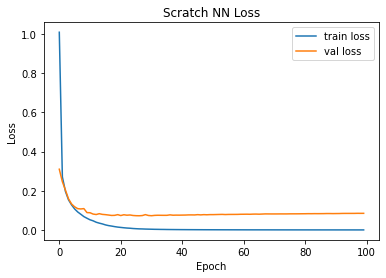

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_loss(model, title='Scratch NN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
    
plot_loss(scratch_nn)

# 【訂正事項】

【問題4】の「3層目」の数式の説明欄
* 誤）$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_nodes2)
* 正）$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_output)